#TP2 Story Points
el dataset se trata de distintos casos de uso para distintos proyectos y nro de story

Alumnos:
* Celestine Raveneau
* Florian Escaffre
* Luis Condori
* Juan Gomez

## Columnas
El conjunto de datos es una serie de casos de uso o user stories de diversos proyectos, para las cuales se tiene el número de story points que indican la complejidad de cada tarea. Se intentará predecir los story points para un texto dado como user story

###*descripción de columnas*

* title: es el título de la user story.

* descripción: es la descripción de la user story.

* project: es el nombre del proyecto en el cual esa user story se crea.

* storypoint: es el puntaje (nivel de complejidad) de la user story.

#Cargo los datasets

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns
!pip install scikit-learn

#Imports para generar los modelos
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#importo los archivos

In [96]:
test=pd.read_csv('/content/drive/MyDrive/Ta047-tp_2do_cuat_2024_grupo_2/TP2/datasets/test.csv')
train=pd.read_csv('/content/drive/MyDrive/Ta047-tp_2do_cuat_2024_grupo_2/TP2/datasets/train.csv')
sample_solution=pd.read_csv('/content/drive/MyDrive/Ta047-tp_2do_cuat_2024_grupo_2/TP2/datasets/sample_solution.csv')

In [97]:
train

,id,title,description,project,storypoint
0,5660,Error enabling Appcelerator services during ap...,"When creating the default app, I encountered t...",project8,3
1,9014,Create a maintenance branch,"As a developer, I'd like to have a maintenance...",project6,5
2,4094,Service Activity Monitoring Backend integrated...,SAM API used by SAM GUI,project1,5
3,811,fs::enter(rootfs) does not work if 'rootfs' is...,I noticed this when I was testing the unified ...,project5,2
4,4459,transform processor with script option is broken,Creating the following stream throws exception...,project6,2
...,...,...,...,...,...
7895,5734,"As Patrick, I want to be able to create a new ...",# Dialog is shown # fields we need to populat...,project7,3
7896,5191,GMock warning in ReservationTest.ACLMultipleOp...,{noformat} [ RUN ] ReservationTest.ACLMu...,project5,1
7897,5390,WSDL Improvement of the SOAP based Service Loc...,As developer I want to use a service that foll...,project1,3
7898,860,Platform Config Wizard: Auto-check if Tizen is...,This is an extension of TISTUD-5246. When the ...,project8,3


<ipython-input-98-0d72bc35b046>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(train, x='storypoint', y='project', inner='box', palette='Dark2')


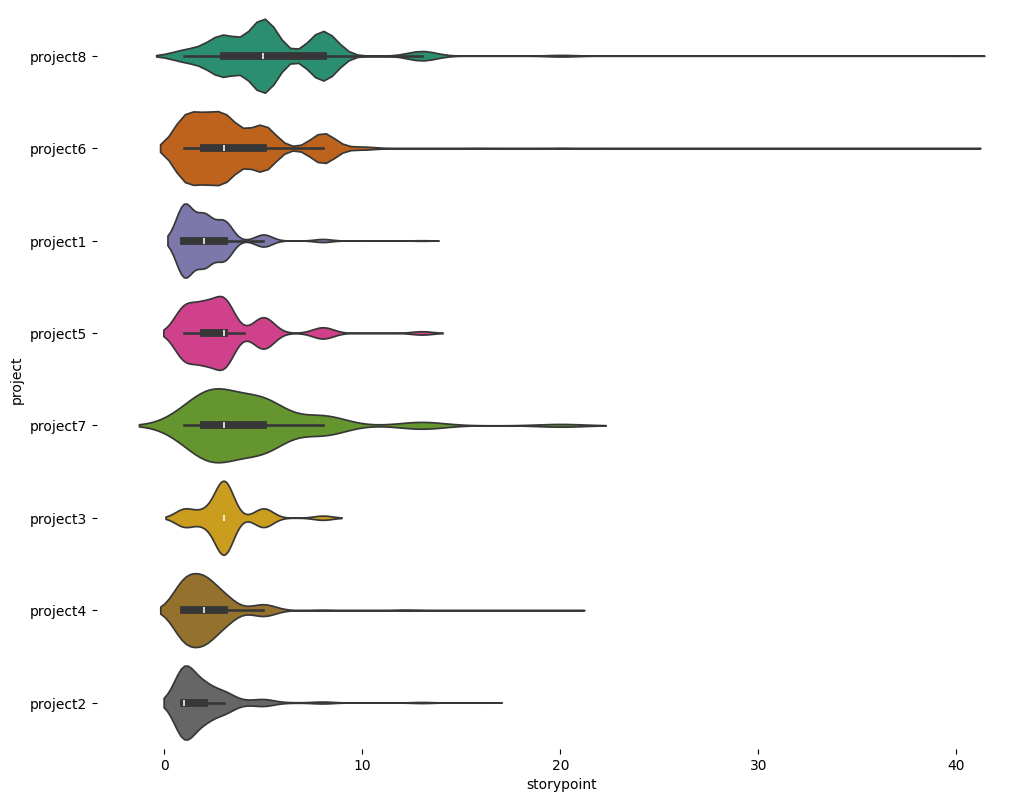

In [98]:
# @title project vs storypoint

figsize = (12, 1.2 * len(train['project'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(train, x='storypoint', y='project', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

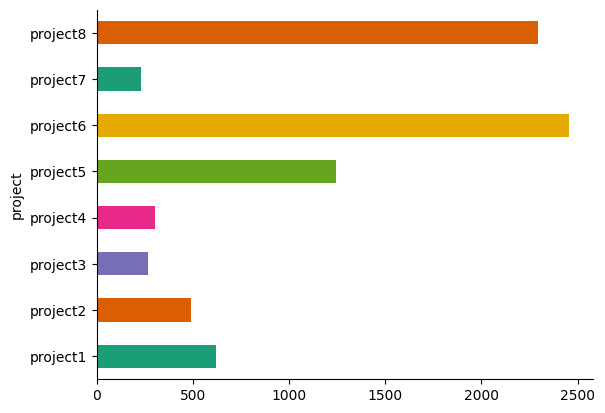

In [99]:
# @title project

train.groupby('project').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

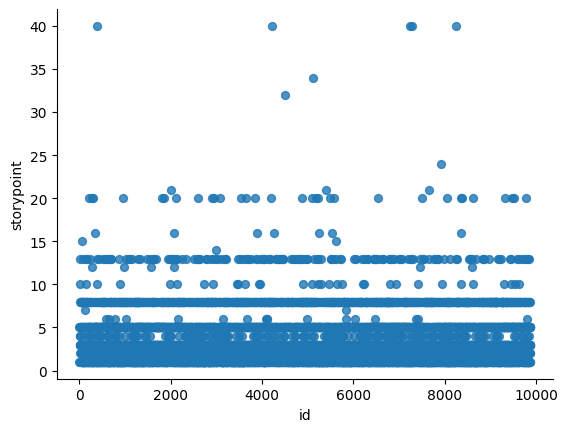

In [100]:
# @title id vs storypoint

train.plot(kind='scatter', x='id', y='storypoint', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# Aplico modelos

● Bayes Naïve

● Random Forest

● XGBoost

● Un modelo de red neuronal aplicando Keras y Tensor Flow.

● Un ensamble de al menos 3 modelos elegidos por el grupo.

#TODO: fala buscar los hiperparametros para cada modelo y generar archivo de salida

##modelo de bayes naive

In [101]:
# Define las características (X) y la variable objetivo (y)
X = train[['title']]
y = train['storypoint']

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Crea una instancia del vectorizador TF-IDF
vectorizer = TfidfVectorizer()

# Ajusta el vectorizador a los datos de entrenamiento y transforma los datos
X_train_vec = vectorizer.fit_transform(X_train['title'])
X_test_vec = vectorizer.transform(X_test['title']) # Usa el mismo vocabulario entrenado con el train

# Crea una instancia del clasificador Gaussian Naive Bayes
gnb = GaussianNB()

# Entrena el modelo con los datos de entrenamiento vectorizados
gnb.fit(X_train_vec.toarray(), y_train) # GaussianNB necesita un array denso

# Realiza predicciones sobre los datos de prueba vectorizados
y_pred = gnb.predict(X_test_vec.toarray())

# Evalúa la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE del modelo: {rmse}')

Precisión del modelo: 0.23645569620253165
RMSE del modelo: 4.035914716013795


## falta generar el archivo con el resultado del modelo

##Modelo Random Forest

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer # Import TfidfVectorizer

# Define las características (X) y la variable objetivo (y)
X = train[['title']]  # Reemplaza 'id' con las columnas que usarás como características
y = train['storypoint']  # Reemplaza 'storypoint' con la columna de tu variable objetivo

# Divide los datos en conjuntos de entrenamiento y prueba
# This was likely done in a previous step but is not shown in the code snippet
# Provided here for completeness and to run the example
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Crea una instancia del vectorizador TF-IDF
vectorizer = TfidfVectorizer()

# Ajusta el vectorizador a los datos de entrenamiento y transforma los datos
X_train_vec = vectorizer.fit_transform(X_train['title'])
X_test_vec = vectorizer.transform(X_test['title']) # Usa el mismo vocabulario entrenado con el train


# Crea una instancia del clasificador Random Forest
rfc = RandomForestClassifier(n_estimators=100, random_state=42)  # Ajusta n_estimators y random_state según tus necesidades

# Entrena el modelo con los datos de entrenamiento vectorizados
rfc.fit(X_train_vec, y_train) # Changed to use vectorized data

# Realiza predicciones sobre los datos de prueba vectorizados
y_pred = rfc.predict(X_test_vec) # Changed to use vectorized data

# Evalúa la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE del modelo: {rmse}')

Precisión del modelo: 0.36
RMSE del modelo: 3.07739821063759


##modelo XG Boost

In [103]:
import xgboost as xgb
# 1. Create a TfidfVectorizer instance
vectorizer = TfidfVectorizer()

# 2. Fit the vectorizer to the training data and transform
X_train_vec = vectorizer.fit_transform(X_train['title'])
X_test_vec = vectorizer.transform(X_test['title']) # Transform test data using the same vectorizer

# Create an XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model using the vectorized data
xgb_model.fit(X_train_vec, y_train) # Changed to use vectorized data

# Make predictions on the test set using vectorized data
y_pred = xgb_model.predict(X_test_vec)  # Changed to use vectorized data

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'RMSE: {rmse}')

RMSE: 2.8983617417405636


## Modelo de red neuronal

In [105]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 1. Create a TfidfVectorizer instance
vectorizer = TfidfVectorizer()

# 2. Fit the vectorizer to the training data and transform
X_train_vec = vectorizer.fit_transform(X_train['title']).toarray() # Convert to dense array
X_test_vec = vectorizer.transform(X_test['title']).toarray() # Convert to dense array

# 3. Define the model
# Adjust input_shape to match the number of features after vectorization
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train_vec.shape[1]]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1) # Output layer with 1 neuron for regression
])

# 4. Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae']) # Use 'mse' loss for regression

# 5. Train the model using the vectorized data
model.fit(X_train_vec, y_train, epochs=100, batch_size=32, validation_split=0.2)

# 6. Evaluate the model using the vectorized data
loss, mae = model.evaluate(X_test_vec, y_test, verbose=0)
print(f'Mean Absolute Error: {mae}')

# 7. Make predictions using the vectorized data
y_pred = model.predict(X_test_vec) # Remove the second prediction using X_test
# The model expects vectorized data, so we should use X_test_vec for prediction

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 17.0428 - mae: 3.0129 - val_loss: 7.9844 - val_mae: 1.9191
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.9616 - mae: 1.7952 - val_loss: 7.5047 - val_mae: 1.8789
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2441 - mae: 1.4904 - val_loss: 7.6120 - val_mae: 1.8702
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3756 - mae: 1.2340 - val_loss: 7.9974 - val_mae: 1.9234
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.2467 - mae: 1.0907 - val_loss: 8.6605 - val_mae: 2.0731
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6321 - mae: 0.9472 - val_loss: 8.9909 - val_mae: 2.1108
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4768 - mae: 0.8476 - val_loss: 9.2459 - val_mae: 2.1153
Epoch 8/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.2321 - mae: 0.6965 - val_loss: 9.7638 - val_mae: 2.1991
Epoch 9/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 9m

##Algoritmo SOM

In [113]:
!pip install scikit-learn
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Access the first column of X_train using integer indexing (0)
le.fit(np.concatenate((X_train[:, 0], X_test[:, 0])))  # Fit on both train and test data

# Transform the first column in both training and test data
X_train_numeric = le.transform(X_train[:, 0]).reshape(-1, 1).astype(float)
X_test_numeric = le.transform(X_test[:, 0]).reshape(-1, 1).astype(float)

# Normalize your data (important for SOM)
X_train_norm = (X_train_numeric - np.min(X_train_numeric)) / (np.max(X_train_numeric) - np.min(X_train_numeric))
X_test_norm = (X_test_numeric - np.min(X_test_numeric)) / (np.max(X_test_numeric) - np.min(X_test_numeric))

# Define SOM parameters
som_dim = (10, 10)  # Dimensions of the SOM grid (adjust as needed)
input_len = X_train_norm.shape[1]  # Number of features
sigma = 0.3  # Spread of the neighborhood function
learning_rate = 0.5  # Initial learning rate

# Create the SOM object
som = MiniSom(som_dim[0], som_dim[1], input_len, sigma=sigma, learning_rate=learning_rate)

# Train the SOM
som.train_batch(X_train_norm, num_iteration=1000)  # Adjust num_iteration as needed

# Get the winning neuron for each test sample
winning_neurons = [som.winner(x) for x in X_test_norm]

# Get the weights of the winning neurons (these represent the predictions)
y_pred = [som.get_weights()[neuron[0], neuron[1]][0] for neuron in winning_neurons]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 4.554433506832972


##Perceptron

In [115]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer # Import TfidfVectorizer

# 1. Create a TfidfVectorizer instance
vectorizer = TfidfVectorizer()

# 2. Fit the vectorizer to the training data and transform
# Assuming X_train and X_test have a 'title' column
X_train_vec = vectorizer.fit_transform(X_train[:, 0]).toarray() # Convert to dense array
X_test_vec = vectorizer.transform(X_test[:, 0]).toarray() # Convert to dense array

# 3. Scale your features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_vec)  # Use vectorized data
X_test_scaled = scaler.transform(X_test_vec)      # Use vectorized data

# 4. Create and train the Perceptron model:
perceptron = Perceptron(random_state=42)
perceptron.fit(X_train_scaled, y_train)

# 5. Make predictions:
y_pred = perceptron.predict(X_test_scaled)

# 6. Calculate RMSE:
from sklearn.metrics import mean_squared_error  # Import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 4.65715727929073
